In [1]:
%run 'Lib.ipynb'

In [2]:
from collections import defaultdict
import pickle
from PIL import Image
import numpy as np

In [3]:
import keras.backend as K
from keras.datasets import mnist
from keras.layers import *
from keras.layers.convolutional import *
from keras.layers.noise import GaussianNoise
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import *
from keras.backend.common import _EPSILON
from keras.utils.generic_utils import Progbar

Using TensorFlow backend.


In [4]:
np.random.seed(123)

In [5]:
K.set_image_dim_ordering('tf')

In [6]:
def modified_binary_crossentropy(target, output):
    #output = K.clip(output, _EPSILON, 1.0 - _EPSILON)
    #return -(target * output + (1.0 - target) * (1.0 - output))
    return K.mean(target * output)

In [14]:
def create_D():
    input_image = Input(shape=(28, 28, 1), name='input_image')

    x = Conv2D(32, (3, 3), padding='same', name='conv_1')(input_image)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding='same', name='conv_2')(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv_3')(x)
    x = MaxPool2D(pool_size=2)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), padding='same', name='coonv_4')(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    features = Flatten()(x)

    output_is_fake = Dense(
        1, activation='linear', name='output_is_fake')(features)
    output_class = Dense(
        10, activation='softmax', name='output_class')(features)

    return Model(inputs=[input_image], outputs=[output_is_fake, output_class])

In [15]:
d = create_D()
d.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_image (InputLayer)         (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv_1 (Conv2D)                  (None, 28, 28, 32)    320         input_image[0][0]                
____________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)       (None, 28, 28, 32)    0           conv_1[0][0]                     
____________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D)  (None, 14, 14, 32)    0           leaky_re_lu_13[0][0]             
___________________________________________________________________________________________

In [20]:
# d.predict([np.zeros([1,28,28,1])])

[array([[ 0.]], dtype=float32),
 array([[ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1]], dtype=float32)]

In [88]:
Z_SIZE = 100

BATCH_SIZE = 1
DICT_LEN = 10
EMBEDDING_LEN = Z_SIZE
INPUT_SEQ_LEN = 1

In [89]:
model = Sequential()

model.add(
    Embedding(
        DICT_LEN,
        EMBEDDING_LEN,
        input_length=INPUT_SEQ_LEN,
        embeddings_initializer='glorot_uniform'))

model.add(Flatten())

In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 1, 100)            1000      
_________________________________________________________________
flatten_17 (Flatten)         (None, 100)               0         
Total params: 1,000
Trainable params: 1,000
Non-trainable params: 0
_________________________________________________________________


In [104]:
input_class = Input(shape=(1, ), dtype='int32')
e = Embedding(10, EMBEDDING_LEN, embeddings_initializer='glorot_uniform')(input_class)
embedded_class = Flatten(name='embedded_class')(e)

In [105]:
input_z = Input(shape=(Z_SIZE, ), name='input_z')

In [124]:
h = multiply([input_z, embedded_class], name='h')

In [125]:
# cnn part
x = Dense(1024)(h)
x = LeakyReLU()(x)

x = Dense(128 * 7 * 7)(x)
x = LeakyReLU()(x)
x = Reshape((7, 7, 128))(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(256, (5, 5), padding='same')(x)
x = LeakyReLU()(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(128, (5,5), padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(1, (2, 2), padding='same', activation='tanh')(x)

In [126]:
model = Model(inputs=[input_class, input_z], outputs=x)

In [127]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_19 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_28 (Embedding)         (None, 1, 100)        1000        input_19[0][0]                   
____________________________________________________________________________________________________
input_z (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedded_class (Flatten)         (None, 100)           0           embedding_28[0][0]               
___________________________________________________________________________________________

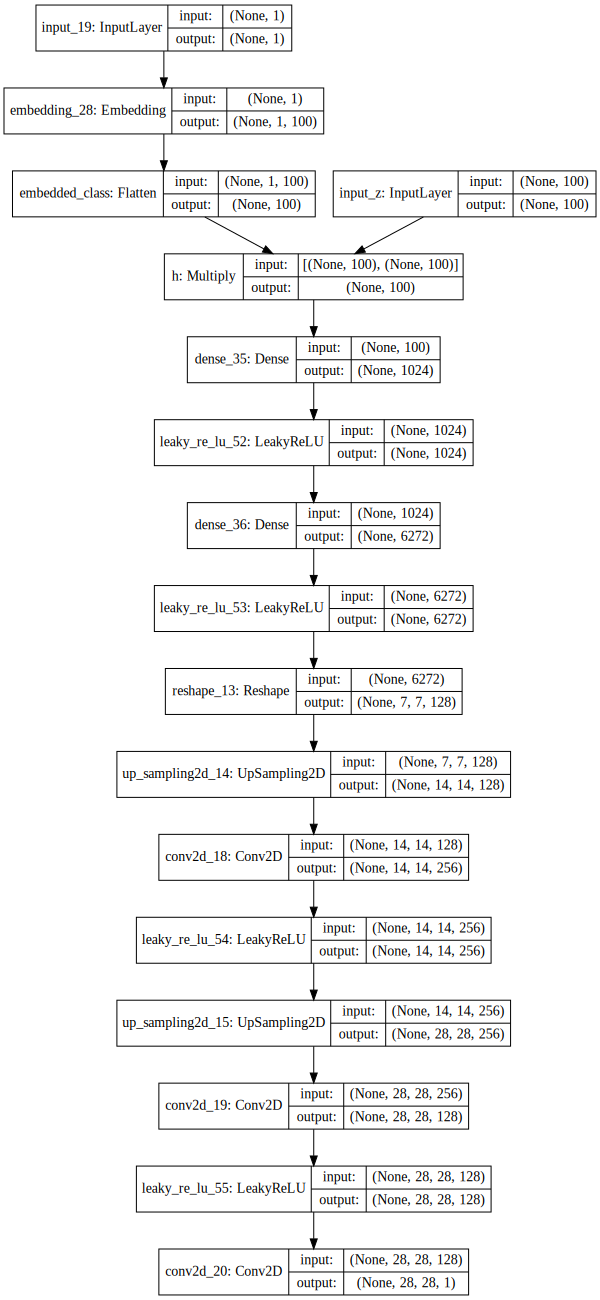

In [128]:
model_as_svg(model)

In [22]:
def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 1, 28, 28)
    cnn = Sequential()

    cnn.add(Dense(1024, input_dim=latent_size))
    cnn.add(LeakyReLU())
    cnn.add(Dense(128 * 7 * 7))
    cnn.add(LeakyReLU())
    cnn.add(Reshape((128, 7, 7)))

    # upsample to (..., 14, 14)
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(
        Convolution2D(256, 5, 5, border_mode='same', init='glorot_uniform'))
    cnn.add(LeakyReLU())

    # upsample to (..., 28, 28)
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(
        Convolution2D(128, 5, 5, border_mode='same', init='glorot_uniform'))
    cnn.add(LeakyReLU())

    # take a channel axis reduction
    cnn.add(
        Convolution2D(
            1,
            2,
            2,
            border_mode='same',
            activation='tanh',
            init='glorot_uniform'))

    # this is the z space commonly refered to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(1, ), dtype='int32')

    # 10 classes in MNIST
    cls = Flatten()(
        Embedding(10, latent_size, init='glorot_uniform')(image_class))

    # hadamard product between z-space and a class conditional embedding
    h = merge([latent, cls], mode='mul')

    fake_image = cnn(h)

    return Model(input=[latent, image_class], output=fake_image)

In [23]:
m = build_generator(123)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), padding="same", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (2, 2), padding="same", activation="tanh", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(10, 123, embeddings_initializer="glorot_uniform")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use inst

In [24]:
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 123)        1230        input_5[0][0]                    
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 123)           0                                            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 123)           0           embedding_1[0][0]                
___________________________________________________________________________________________

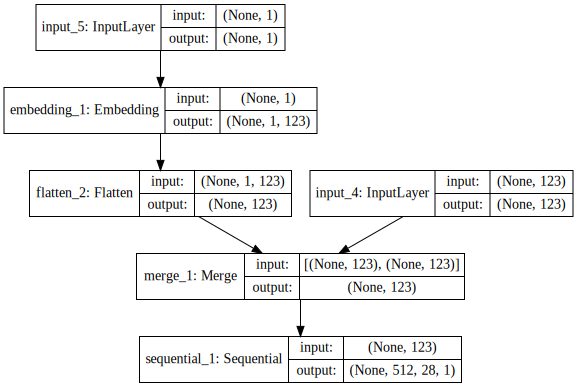

In [25]:
model_as_svg(m)

In [9]:
# batch and latent size taken from the paper
nb_epochs = 50
batch_size = 100
latent_size = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

In [ ]:
discriminator.compile(
    optimizer=SGD(clipvalue=0.01),  #Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=[modified_binary_crossentropy, 'sparse_categorical_crossentropy'])